# Detekcja krawędzi

## Cel ćwiczenia

- Zapoznanie z metodami detekcji krawędzi:
    - Sobel, Prewitt, Roberts - przypomnienie,
    - Laplasjan z Gaussa (LoG – ang. Laplacian of Gaussian),
    - Canny.

Detekcja krawędzi przez wiele lat była podstawą algorytmów segmentacji.
Krawędzie wykrywane są najczęściej z wykorzystaniem pierwszej (gradient) i drugiej (Laplasjan) pochodnej przestrzennej.
Wykorzystanie obu metod zaprezentowane zostało w ćwiczeniu *Przetwarzanie wstępne. Filtracja kontekstowa*.

W niniejszym ćwiczeniu poznane detektory krawędzi zostaną porównane z bardziej zaawansowanymi: Laplasjan z funkcji Gaussa (LoG), Zero Crossing i Canny.

## Laplasjan z Gaussa (LoG)

Funkcja Gaussa:<br>
\begin{equation}
h(r) = e^{\frac{-r^2}{2 \sigma^2}}
\end{equation}<br>
gdzie:
- $r^2 = x^2 + y^2$
- $\sigma$ to odchylenie standardowe.

Działanie filtracji Gaussowskiej zostało przedstawione w ćwiczeniu "Przetwarzanie wstępne". W jej wyniku następuje rozmazanie obrazu.
Laplasjan tej funkcji dany jest wzorem:

\begin{equation}
\nabla^2 h(r) = \frac{r^2 - 2\sigma^2}{\sigma^4} e^{-\frac{r^2}{2\sigma^2}}
\end{equation}

Funkcję (z oczywistych powodów) nazywamy Laplasjan z Gaussa (LoG).
Ponieważ druga pochodna jest operacją liniową, konwolucja obrazu z $\nabla^2 h(r)$ daje taki sam efekt jak zastosowanie filtracji Gaussa na obrazie, a następnie obliczenie Laplasjanu z wyniku.
Lokalizacja krawędzi polega na znalezieniu miejsca, gdzie po filtracji LoG następuje zmiana znaku.

1. Wczytaj obraz *house.png*.
2. Wykonaj rozmycie Gaussowskie obrazu wejściowego.
W tym celu wykorzysaj funkcję `cv2.GaussianBlur(img, kSize, sigma)`.
Pierwszy argument jest obrazem wejśćiowym.
Drugi jest rozmiarem filtru (podanym w nawiasach okrągłych, np. *(3, 3)*).
Trzecim argumentem jest odchylenie standardowe. Wartość jest dobrana automatycznie, jeśli zosanie podana wartość `0` (będą równe rozmiarowi).
3. Oblicz laplasjan obrazu rozmytego.
W tym celu wykorzysaj funkcję `cv2.Laplacian(img, ddepth)`.
Pierszym argumentem jest obraz wejściowy.
Drugim argumentem jest typ danych wejściowych. Użyj `cv2.CV_32F`.
4. Wyznacz miejsca zmiany znaku.
Zaimplementuj funkcję `crossing(LoG, thr)`:
    - Najpierw stwórz tablicę, do której zostanie zapisany wynik.
    Jej rozmiar jest taki sam jak przetwarzanego obrazu.
    - Następnie wykonaj pętle po obrazie (bez ramki jednopikselowej).
    W każdej iteracji stwórz otoczenie o rozmiarze $3 \times 3$.
    Dla otoczenia oblicz wartość maksymalną i minimalną.
    - Jeśli wartości te mają przeciwne znaki, to do danego miejsca tablicy przypisz wartość:
        - jeśli piksel wejściowy > 0, to dodaj do niego wartość bezwzględną minimum.
        - jeśli piksel wejściowy < 0, to do jego wartości bezwzględnej dodaj maksimum.
    - Zmień zakres wykonanej tablicy do $<0, 255>$.
    - Wykonaj progowanie tablicy. Próg jest argumentem wejściowym.
    - Przeskaluj dane binarne do wartości `[0, 255]`.
    - Wykonaj konwersję do typu *uint8*.
    - Wykonaj rozmycie medianowe wyniku.
    Wykorzystaj funkcję `cv2.medianBlur(img, kSize)`.
    Pierwszym argumentem jest obraz wejśćiowy, a drugim rozmiar filtra.
    - Zwróć wyznaczoną tablicę.
5. Wyświetl obraz wynikowy.
6. Dobierz parametry (rozmiar filtru Gaussa, odchylenie standardowe, próg binaryzacji) tak, by widoczne były kontury domu, ale nie dachówki.

In [1]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import math
import os

if not os.path.exists("dom.png") :
    !wget https://raw.githubusercontent.com/vision-agh/poc_sw/master/09_Canny/dom.png --no-check-certificate



In [2]:
house_image = cv2.imread('dom.png', cv2.IMREAD_GRAYSCALE)

Text(0.5, 1.0, 'Obraz oryginalny')

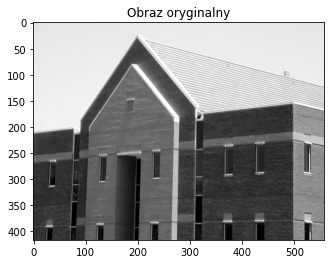

In [78]:
plt.imshow(house_image, 'gray')
plt.title('Obraz oryginalny')

In [4]:
house_blurred = cv2.GaussianBlur(house_image, (3,3), 0)

Text(0.5, 1.0, 'Obraz rozmyty')

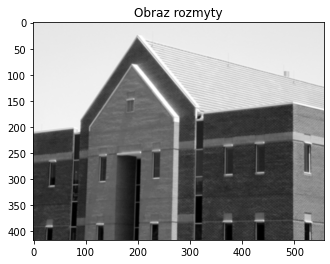

In [5]:
plt.imshow(house_blurred, 'gray')
plt.title('Obraz rozmyty')

In [6]:
house_laplace = cv2.Laplacian(house_blurred, cv2.CV_32F)

Text(0.5, 1.0, 'Laplasjan obrazu rozmytego')

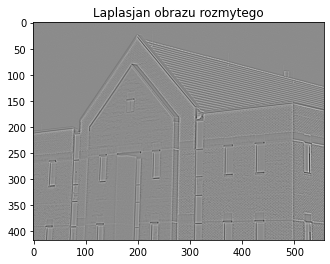

In [7]:
plt.imshow(house_laplace, 'gray')
plt.title('Laplasjan obrazu rozmytego')

In [8]:
def crossing(log, thr):
    result = np.zeros(np.shape(log))
    
    for i in range(1, np.shape(log)[0] - 1):
        for j in range(1, np.shape(log)[1] - 1):
            surroundings = log[i-1:i+2,j-1:j+2]
            
            min_val = np.min(surroundings)
            max_val = np.max(surroundings)
                
            if min_val * max_val < 0:
                if log[i, j] > 0:
                    result[i, j] = log[i, j] + np.abs(min_val)
                else:
                    result[i, j] = np.abs(log[i, j]) + max_val
                    
    maximum = np.max(result)
    scale_factor = 255 / maximum
    result *= scale_factor
    
    result = np.where(result > thr, 255, 0).astype('uint8')
    
    median_blurred = cv2.medianBlur(result, 3)
    
    return median_blurred

In [9]:
def get_laplace(image, size, sigma):
    blurred = cv2.GaussianBlur(house_image, (size,size), sigma)
    return cv2.Laplacian(blurred, cv2.CV_32F)

Text(0.5, 1.0, 'Obraz wynikowy z odpowienio dobranymi parametrami')

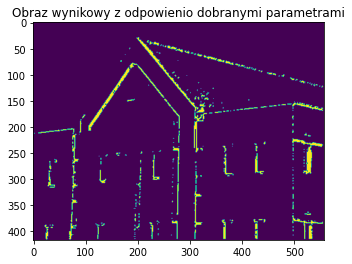

In [10]:
plt.imshow(crossing(get_laplace(house_image,7, 0), 70))
plt.title("Obraz wynikowy z odpowienio dobranymi parametrami")

## Algorytm Canny'ego

> Algorytm Canny'ego to często wykorzystywana metoda detekcji krawędzi.
> Zaproponowana została w 1986r. przez Johna F. Cannego.
> Przy jego projektowaniu założono trzy cele:
> - niska liczba błędów - algorytm powinien znajdywać wszystkie krawędzie oraz generować jak najmniej fałszywych detekcji,
> - punkty krawędziowe powinny być poprawnie lokalizowane - wykryte punkty powinny być jak najbardziej zbliżone do rzeczywistych,
> - krawędzie o szerokości 1 piksela - algorytm powinien zwrócić jeden punkt dla każdej rzeczywistej krawędzi.

Zaimplementuj algorytm detekcji krawędziCanny'ego:
1. W pierwszym kroku obraz przefiltruj dwuwymiarowym filtrem Gaussa.
2. Następnie oblicz gradient pionowy i poziomy ($g_x $ i $g_y$).
Jedną z metod jest filtracja Sobela.
3. Dalej oblicz amplitudę:
$M(x,y)  = \sqrt{g_x^2+g_y^2}$ oraz kąt:
$\alpha(x,y) = arctan(\frac{g_y}{g_x})$.
Do obliczenia kąta wykorzystaj funkcję `np.arctan2(x1, x2)`.
Wynik jest w radianach.
4. W kolejnym etapie wykonaj kwantyzację kątów gradientu.
Kąty od $-180^\circ$ do $180^\circ$ można podzielić na 8 przedziałów:
[$-22.5^\circ, 22.5^\circ$], [$22.5^\circ, 67.5^\circ$],
[$67.5^\circ, 112.5^\circ$], [$112.5^\circ, 157.5^\circ$],
[$157.5^\circ, -157.5^\circ$], [$-157.5^\circ, -112.5^\circ$],
[$-112.5^\circ, -67.5^\circ$], [$-67.5^\circ, -22.5^\circ$].
Przy czym należy rozpatrywać tylko 4 kierunki:
    - pionowy ($d_1$),
    - poziomy ($d_2$),
    - skośny lewy ($d_3$),
    - skośny prawy ($d_4$).
5. Dalej przeprowadź eliminację pikseli, które nie mają wartości maksymalnej (ang. *nonmaximal suppresion*).
Celem tej operacji jest redukcja szerokości krawędzi do rozmiaru 1 piksela.
Algorytm przebiega następująco.
W rozpatrywanym otoczeniu o rozmiarze $3 \times 3$:
    - określ do którego przedziału należy kierunek gradientu piksela centralnego ($d_1, d_2, d_3, d_4$).
    - przeanalizuje sąsiadów leżących na tym kierunku.
Jeśli choć jeden z nich ma amplitudę większą niż piksel centralny, to należy uznać, że nie jest lokalnym maksimum i do wyniku przypisać $g_N(x,y) = 0$.
W przeciwnym przypadku $g_N(x,y) = M(x,y)$.
Przez $g_N$ rozumiemy obraz detekcji lokalnych maksimów.
Zaimplementuj funkcję `nonmax`.
Pierwszym argementem jest macierz kierunków (po kwantyzacji).
Drugim argumentem jest macierz amplitudy.
6. Ostatnią operacją jest binaryzacja obrazu $g_N$.
Stosuje się tutaj tzw. binaryzację z histerezą.
Wykorzystuje się w niej dwa progi: $T_L$ i $T_H$, przy czym $T_L < T_H$.
Canny zaproponował, aby stosunek progu wyższego do niższego był jak 3 lub 2 do 1.
Rezultaty binaryzacji można opisać jako:<br>
$g_{NH}(x,y) = g_N(x,y) \geq TH $<br>
$g_{NL}(x,y) = TH > g_N(x,y) \geq TL $<br>
Można powiedzieć, że na obrazie $g_{NH}$ są "pewne" krawędzie.
Natomiast na $g_{NL}$ "potencjalne".
Często krawędzie "pewne" nie są ciągłe.
Dlatego wykorzystuje się obraz $g_{NL}$ w następującej procedurze:
    - Stwórz stos zawierający wszystkie piksele zaznaczone na obrazie $g_{NH}$.
W tym celu wykorzystaj listę współrzędnych `[row, col]`.
Do pobrania elementu z początku służy metoda `list.pop()`.
Do dodania elementu na koniec listy służy metoda `list.append(new)`.
    - Stwórz obraz, który będzie zawierał informację czy dany piksel został już odwiedzony.
    - Stwórz obraz, któy zawierać będzie wynikowe krawędzie.
Jej rozmiar jest równy rozmiarowi obrazu.
    - Wykonaj pętlę, która będzie pobierać elementy z listy, dopóki ta nie będzie pusta.
W tym celu najlepiej sprawdzi się pętla `while`.
    - W każdej iteracji pobierz element ze stosu.
    - Sprawdź czy dany element został już odwiedzony.
    - Jeśli nie został, to:
        - Oznacz go jako odwiedzony,
        - Oznacz piksel jako krawędź w wyniku,
        - Sprawdź otoczenie piksela w obrazie $g_{NL}$,
        - Dodaj do stosu współrzędne otoczenia, które zawierają krawędź (potencjalną).
        Można to wykoanać np. pętlą po stworzonym otoczeniu.
7. Wyświetl obraz oryginalny, obraz $g_{NH}$ oraz obraz wynikowy.

Pomocnicze obrazy $g_{NH}$ i $g_{NL}$ zostały wprowadzone dla uproszczenia opisu.
Algorytm można zaimplementować wbardziej "zwarty" sposób.

Na podstawie powyższego opisu zaimplementuj algorytm Cannego.

In [225]:
def quantify_angles(angle):
    divisions = []
    divisions.append(- np.pi + np.pi / 8)
    for i in range(7):
        divisions.append(divisions[-1] + np.pi / 4)
    
#     print('divisions')
#     print(divisions)
#     print('angle')
#     print(angle)
    #d1 - pion
    d1 = np.where(((divisions[1] <= angle) & (angle < divisions[2])) |  ((divisions[5] <= angle) & (angle < divisions[6])), 1, 0)
    #d2 - poziom
    d2 = np.where((angle < divisions[0]) | ((divisions[3] <= angle) & (angle < divisions[4])) |  (divisions[7] <= angle), 2, 0)
    #d3 - skonsny lewo gora -> prawo dol
    d3 = np.where(((divisions[2] <= angle) & (angle < divisions[3])) |  ((divisions[6] <= angle) & (angle < divisions[7])), 3, 0)
    #d4 - skonsny prawo gora -> lewo dol
    d4 = np.where(((divisions[0] <= angle) & (angle < divisions[1])) |  ((divisions[4] <= angle) & (angle < divisions[5])), 4, 0)
    
    return d1 + d2 + d3 + d4
    

In [226]:
def nonmax(quantified_angles, amplitude):
    gn_xy = np.zeros(np.shape(quantified_angles))
    
#     print('gn_xy')
#     print(gn_xy)
    
    for i in range(1, np.shape(quantified_angles)[0] - 1):
        for j in range(1, np.shape(quantified_angles)[1] - 1):
            central_pixel = quantified_angles[i, j]
            
            if central_pixel == 1:
                neighbors = [amplitude[i-1,j], amplitude[i+1,j]]
            elif central_pixel == 2:
                neighbors = [amplitude[i,j-1], amplitude[i,j+1]]
            elif central_pixel == 3:
                neighbors = [amplitude[i-1,j-1], amplitude[i+1,j+1]]
            elif central_pixel == 4:
                neighbors = [amplitude[i-1,j+1], amplitude[i+1,j-1]]
            else:
                raise Exception('Wrong pixel value at ', i,' ', j,' = ', central_pixel)
                
            if np.max(neighbors) < amplitude[i, j]:
                gn_xy[i, j] = amplitude[i, j]
                
    return gn_xy

In [234]:
def canny(image, TL, TH):
    blurred = cv2.GaussianBlur(image, (3,3), 0)
    
    grad_x = np.array(cv2.Sobel(image, cv2.CV_32F, 1, 0, ksize=3), dtype=np.float64)
    grad_y = np.array(cv2.Sobel(image, cv2.CV_32F, 0, 1, ksize=3), dtype=np.float64)
    
    m_xy = np.sqrt(np.square(grad_x) + np.square(grad_y))
    
#     print('m_xy')
#     print(m_xy)
    
    angle = np.arctan2(grad_y, grad_x)
    
#     print('angle')
#     print(angle)
#     print(np.min(angle))
#     print(np.max(angle))
    
    #quantify angles
    
    quantified_angles = quantify_angles(angle)
    
#     print('quantified_angles')
#     print(quantified_angles)
    g_n = nonmax(quantified_angles, m_xy)
    
#     print('nonmax')
#     print(nonmaxed)
    return g_n, g_n

    g_nh = np.where(TH <= g_n, 1, 0)
    g_nl = np.where((TL <= g_n) & (g_n < TH), 1, 0)
    
    #binarization
    g_nh_nonzero = np.nonzero(g_nh)
#     print('g_nh_nonzero')
#     print(g_nh_nonzero)
    stack = []
    for z in zip(g_nh_nonzero[0], g_nh_nonzero[1]):
        stack.append(z)
#     print('stack')
#     print(stack)
#     print(len(stack))
    visited = np.zeros(np.shape(image))
    resulting_edges = np.zeros(np.shape(image))
    while stack:
        pixel = stack.pop()
        if not visited[pixel]:
            visited[pixel] = 1
            resulting_edges[pixel] = 1
            i, j = pixel 
            
            for k in range(-1, 2):
                for l in range(-1, 2):
                    if (k != 0 or j != 0) and g_nl[i + k, j + l]:
                        stack.append((i + k, j + l))
    
    return g_nh, resulting_edges
#     grad_angle_quant =

Text(0.5, 1.0, 'result_image')

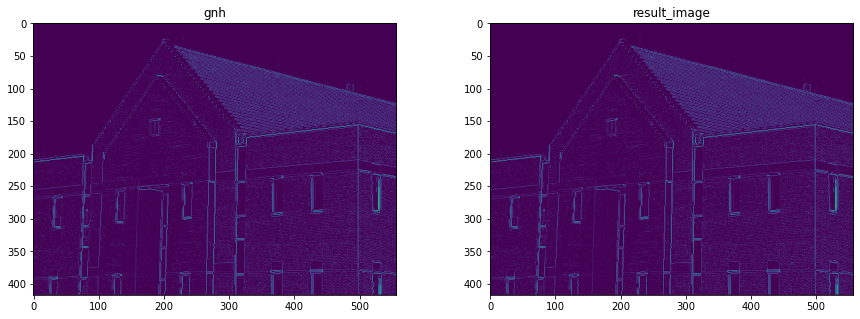

In [235]:
g_nh, result_image = canny(house_image, 100, 250)

fig, axs = plt.subplots(1, 2)
fig.set_size_inches(15, 5)

axs[0].imshow(g_nh)
axs[0].set_title('gnh')
axs[1].imshow(result_image)
axs[1].set_title('result_image')

## Algorytm Canny'ego - OpenCV

1. Wykonaj dektekcję krawędzi metodą Canny'ego wykorzystując funkcję `cv2.Canny`.
    - Pierwszym argumentem funkcji jest obraz wejściowy.
    - Drugim argumentem jest mniejszy próg.
    - Trzecim argumentem jest większy próg.
    - Czwarty argument to tablica, do której wpisany zostanie wynik.
    Można zwrócić go przez wartość i podać wartość `None`.
    - Piąty argument to rozmiar operatora Sobela (w naszym przypadku 3).
    - Szósty argument to rodzaj używanej normy.
    0 oznacza normę $L_1$, 1 oznacza normę $L_2$. Użyj $L_2$.
2. Wynik wyświetl i porównaj z własną implementacją.

Text(0.5, 1.0, 'Obraz wynikowy')

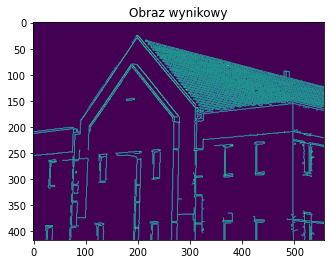

In [233]:
plt.imshow(cv2.Canny(house_image, 100, 250, None, 3, 1))
plt.title("Obraz wynikowy")